<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/Maui_carbon_landuse_climate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install fiona

In [62]:
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
from datetime import datetime
import matplotlib.pyplot as plt

In [63]:
df = gpd.read_file('/content/maui_carbon_analysis_with_polyids.gpkg', engine='fiona')

In [64]:
# Get all the monthly carbon columns
date_cols = [col for col in df.columns if col.startswith('d_')]
print(f"Found {len(date_cols)} monthly predictions")
print(f"Date range: {date_cols[0]} to {date_cols[-1]}")

# Extract year from column names to identify first and last year
def get_year(col):
    date_str = col.split('_')[1]
    return int(date_str[:4])

# Get unique years
years = sorted(set([get_year(col) for col in date_cols]))
first_year = 2017
last_year = 2024

print(f"First year: {first_year}")
print(f"Last year: {last_year}")

# Get columns for first and last year
first_year_cols = [col for col in date_cols if get_year(col) == first_year]
last_year_cols = [col for col in date_cols if get_year(col) == last_year]

print(f"First year columns ({first_year}): {len(first_year_cols)} months")
print(f"Last year columns ({last_year}): {len(last_year_cols)} months")

Found 98 monthly predictions
Date range: d_20161217 to d_20241205
First year: 2017
Last year: 2024
First year columns (2017): 12 months
Last year columns (2024): 12 months


In [65]:
## across subregion, not grouped by polygon

# Calculate mean carbon across all months
df['carbon_mean'] = df[date_cols].mean(axis=1)
df['carbon_median'] = df[date_cols].median(axis=1)
df['carbon_std'] = df[date_cols].std(axis=1)
df['carbon_min'] = df[date_cols].min(axis=1)
df['carbon_max'] = df[date_cols].max(axis=1)

# Add first and last year averages
df['carbon_first_year'] = df[first_year_cols].mean(axis=1)
df['carbon_last_year'] = df[last_year_cols].mean(axis=1)

# Calculate change over time
df['carbon_change'] = df['carbon_last_year'] - df['carbon_first_year']
df['carbon_pct_change'] = ((df['carbon_last_year'] - df['carbon_first_year']) /
                                       df['carbon_first_year']) * 100

# Use the temporal mean for summaries
carbon_col = 'carbon_mean'

print(f"\nCarbon statistics:")
print(f"  Overall mean: {df['carbon_mean'].mean():.2f}%")
print(f"  First year ({first_year}) mean: {df['carbon_first_year'].mean():.2f}%")
print(f"  Last year ({last_year}) mean: {df['carbon_last_year'].mean():.2f}%")
print(f"  Average change: {df['carbon_change'].mean():.2f}% ({df['carbon_pct_change'].mean():.2f}% change)")


Carbon statistics:
  Overall mean: 3.71%
  First year (2017) mean: 4.04%
  Last year (2024) mean: 3.19%
  Average change: -0.76% (-22.08% change)


In [80]:
# Group by polygon and calculate statistics - UPDATED to include Suborder
polygon_summary = df.groupby('polygonid').agg({
    # Take first value for categorical/constant columns
    'landuse_historic': 'first',
    'landuse_current': 'first',
    'land_use_transition': 'first',
    'climate_description': 'first',
    'Suborder': 'first',  # ADD THIS LINE
    'geometry': 'first',

    # Calculate mean across all points in each polygon for carbon metrics
    'carbon_mean': 'mean',
    'carbon_median': 'mean',
    'carbon_std': 'mean',
    'carbon_min': 'mean',
    'carbon_max': 'mean',
    'carbon_first_year': 'mean',
    'carbon_last_year': 'mean',
    'carbon_change': 'mean',
    'carbon_pct_change': 'mean'
}).reset_index()

# Convert back to GeoDataFrame
polygon_summary = gpd.GeoDataFrame(polygon_summary, geometry='geometry')

# Filter to keep only transitions with more than 1 polygon
transition_counts = polygon_summary['land_use_transition'].value_counts()
transitions_to_keep = transition_counts[transition_counts > 1].index
polygon_summary_filtered = polygon_summary[polygon_summary['land_use_transition'].isin(transitions_to_keep)]

# Print statistics for filtered dataset
print(f"\n{'='*80}")
print("FILTERED POLYGON-LEVEL CARBON STATISTICS")
print(f"{'='*80}")
print(f"\nFiltering summary:")
print(f"  Original polygons: {len(polygon_summary)}")
print(f"  Filtered polygons: {len(polygon_summary_filtered)}")
print(f"  Original unique transitions: {len(transition_counts)}")
print(f"  Filtered unique transitions: {len(transitions_to_keep)}")
print(f"  Removed transitions (single polygon): {len(transition_counts[transition_counts == 1])}")

print(f"\nOverall statistics:")
print(f"  Mean SOC: {polygon_summary_filtered['carbon_mean'].mean():.2f}%")
print(f"  First year ({first_year}) mean: {polygon_summary_filtered['carbon_first_year'].mean():.2f}%")
print(f"  Last year ({last_year}) mean: {polygon_summary_filtered['carbon_last_year'].mean():.2f}%")
print(f"  Average change: {polygon_summary_filtered['carbon_change'].mean():.2f}% ({polygon_summary_filtered['carbon_pct_change'].mean():.2f}% change)")

# Display summary by land use transition
print(f"\nBy land use transition:")
for transition in sorted(polygon_summary_filtered['land_use_transition'].unique()):
    trans_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]
    print(f"\n  {transition}:")
    print(f"    Polygons: {len(trans_data)}")
    print(f"    Mean SOC: {trans_data['carbon_mean'].mean():.2f}%")
    print(f"    Mean change: {trans_data['carbon_change'].mean():.2f}% ({trans_data['carbon_pct_change'].mean():.2f}%)")


FILTERED POLYGON-LEVEL CARBON STATISTICS

Filtering summary:
  Original polygons: 297
  Filtered polygons: 294
  Original unique transitions: 12
  Filtered unique transitions: 9
  Removed transitions (single polygon): 3

Overall statistics:
  Mean SOC: 4.01%
  First year (2017) mean: 4.14%
  Last year (2024) mean: 3.58%
  Average change: -0.55% (-15.30% change)

By land use transition:

  diversified → diversified:
    Polygons: 34
    Mean SOC: 4.59%
    Mean change: -0.21% (-3.96%)

  diversified → pineapple:
    Polygons: 44
    Mean SOC: 4.79%
    Mean change: -0.14% (-2.48%)

  diversified → rangeland:
    Polygons: 4
    Mean SOC: 4.88%
    Mean change: -0.53% (-10.26%)

  pineapple → abandoned:
    Polygons: 33
    Mean SOC: 4.61%
    Mean change: -0.42% (-8.32%)

  pineapple → rangeland:
    Polygons: 20
    Mean SOC: 4.22%
    Mean change: -0.51% (-11.08%)

  rangeland → rangeland:
    Polygons: 36
    Mean SOC: 5.60%
    Mean change: -0.46% (-8.73%)

  sugarcane → abandoned:

Found 9 unique land use transitions


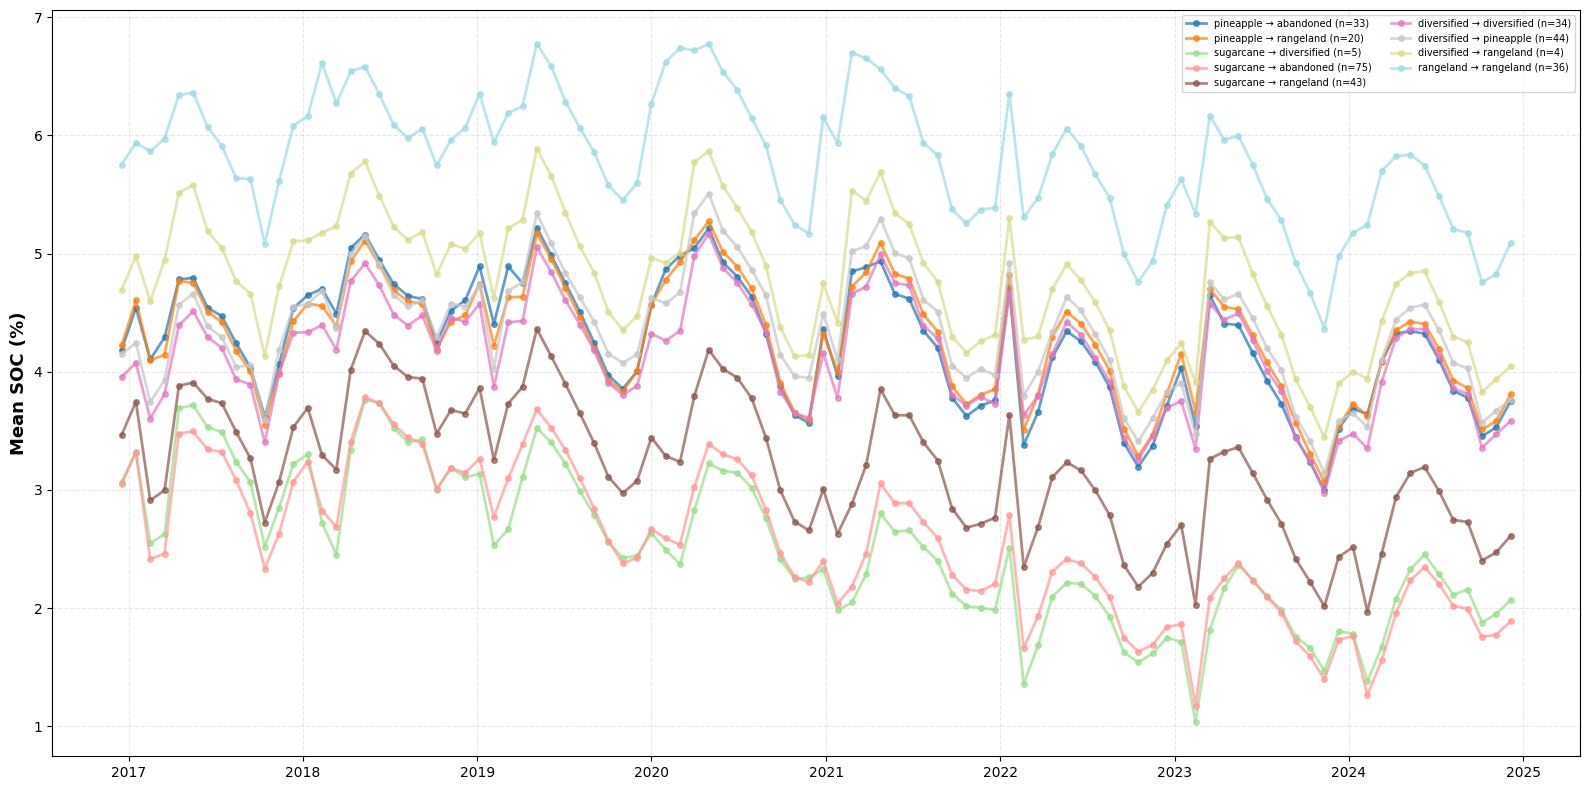

In [67]:
# Get all date columns from polygon_summary dataframe
date_cols = [col for col in df.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Get all unique transitions from polygon_summary_filtered
transitions = polygon_summary_filtered['land_use_transition'].unique()
print(f"Found {len(transitions)} unique land use transitions")

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors for each transition
colors = plt.cm.tab20(np.linspace(0, 1, len(transitions)))

# Plot for each land use transition
for idx, transition in enumerate(transitions):
    # Get polygon IDs for this transition
    polygon_ids = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]['polygonid']

    # Filter original df data for these polygons
    transition_data = df[df['polygonid'].isin(polygon_ids)]

    # Calculate mean for each date across all points in these polygons
    yearly_means = []
    for date_col in date_cols:
        yearly_means.append(transition_data[date_col].mean())

    # Plot
    ax.plot(dates, yearly_means,
            marker='o', linewidth=2, markersize=4,
            label=f'{transition} (n={len(polygon_ids)})',
            color=colors[idx], alpha=0.7)

ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=7, ncol=2)
plt.tight_layout()
plt.show()

Found 9 unique land use transitions


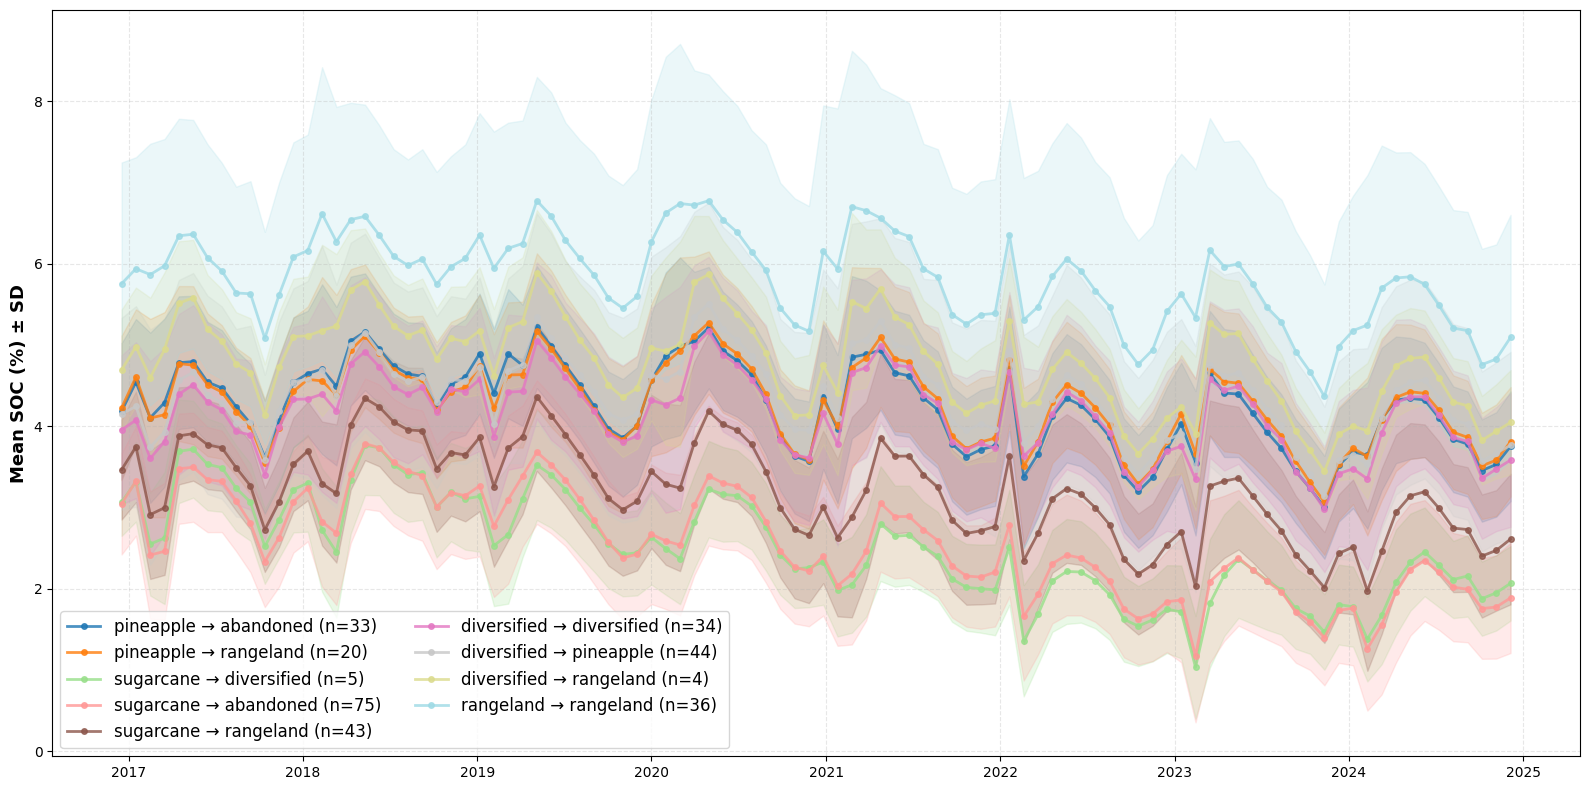

In [68]:
# Get all date columns from df dataframe
date_cols = [col for col in df.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Get all unique transitions from polygon_summary_filtered
transitions = polygon_summary_filtered['land_use_transition'].unique()
print(f"Found {len(transitions)} unique land use transitions")

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors for each transition
colors = plt.cm.tab20(np.linspace(0, 1, len(transitions)))

# Plot for each land use transition
for idx, transition in enumerate(transitions):
    # Get polygon IDs for this transition
    polygon_ids = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]['polygonid']

    # Filter original df data for these polygons
    transition_data = df[df['polygonid'].isin(polygon_ids)]

    # Calculate mean and std for each date across all points in these polygons
    yearly_means = []
    yearly_stds = []
    for date_col in date_cols:
        yearly_means.append(transition_data[date_col].mean())
        yearly_stds.append(transition_data[date_col].std())

    yearly_means = np.array(yearly_means)
    yearly_stds = np.array(yearly_stds)

    # Plot line
    ax.plot(dates, yearly_means,
            marker='o', linewidth=2, markersize=4,
            label=f'{transition} (n={len(polygon_ids)})',
            color=colors[idx], alpha=0.8)

    # Add shaded standard deviation
    ax.fill_between(dates,
                    yearly_means - yearly_stds,
                    yearly_means + yearly_stds,
                    color=colors[idx], alpha=0.2)

ax.set_ylabel('Mean SOC (%) ± SD', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower left', fontsize=12, ncol=2)
plt.tight_layout()
plt.show()

In [69]:
# Create summary dataframe from polygon_summary_filtered with increase/decrease counts
summary_data = []

for transition in polygon_summary_filtered['land_use_transition'].unique():
    transition_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]

    # Get statistics directly from polygon-level data
    mean_soc = transition_data['carbon_mean'].mean()
    std_soc = transition_data['carbon_mean'].std()
    first_year_mean = transition_data['carbon_first_year'].mean()
    last_year_mean = transition_data['carbon_last_year'].mean()
    change = transition_data['carbon_change'].mean()
    pct_change = transition_data['carbon_pct_change'].mean()

    # Count increases and decreases
    n_increased = (transition_data['carbon_change'] > 0).sum()
    n_decreased = (transition_data['carbon_change'] < 0).sum()

    summary_data.append({
        'Transition': transition,
        'N Polygons': len(transition_data),
        'N Increased': n_increased,
        'N Decreased': n_decreased,
        'Mean SOC (%)': round(mean_soc, 2),
        'Std Dev (%)': round(std_soc, 2),
        f'SOC {first_year} (%)': round(first_year_mean, 2),
        f'SOC {last_year} (%)': round(last_year_mean, 2),
        'Absolute Change (%)': round(change, 2),
        'Change (% relative)': round(pct_change, 1)
    })

# Create DataFrame
summary_table = pd.DataFrame(summary_data)
summary_table = summary_table.sort_values(['N Polygons'], ascending=[False])

print("\n" + "="*120)
print("LAND USE TRANSITION SUMMARY (POLYGON LEVEL)")
print("="*120)

# Display with nice formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

display(summary_table)


LAND USE TRANSITION SUMMARY (POLYGON LEVEL)


,Transition,N Polygons,N Increased,N Decreased,Mean SOC (%),Std Dev (%),SOC 2017 (%),SOC 2024 (%),Absolute Change (%),Change (% relative)
3,sugarcane → abandoned,75,1,74,2.64,0.57,3.04,2.06,-0.98,-32.5
6,diversified → pineapple,44,12,32,4.79,0.98,4.63,4.49,-0.14,-2.5
4,sugarcane → rangeland,43,4,39,3.31,0.57,3.53,2.88,-0.64,-18.6
8,rangeland → rangeland,36,3,33,5.60,1.69,5.63,5.16,-0.46,-8.7
5,diversified → diversified,34,10,24,4.59,1.05,4.49,4.28,-0.21,-4.0
0,pineapple → abandoned,33,0,33,4.61,0.34,4.69,4.27,-0.42,-8.3
1,pineapple → rangeland,20,0,20,4.22,0.73,4.37,3.86,-0.51,-11.1
2,sugarcane → diversified,5,0,5,2.48,0.29,3.03,2.00,-1.03,-33.0
7,diversified → rangeland,4,0,4,4.88,0.55,4.98,4.45,-0.53,-10.3


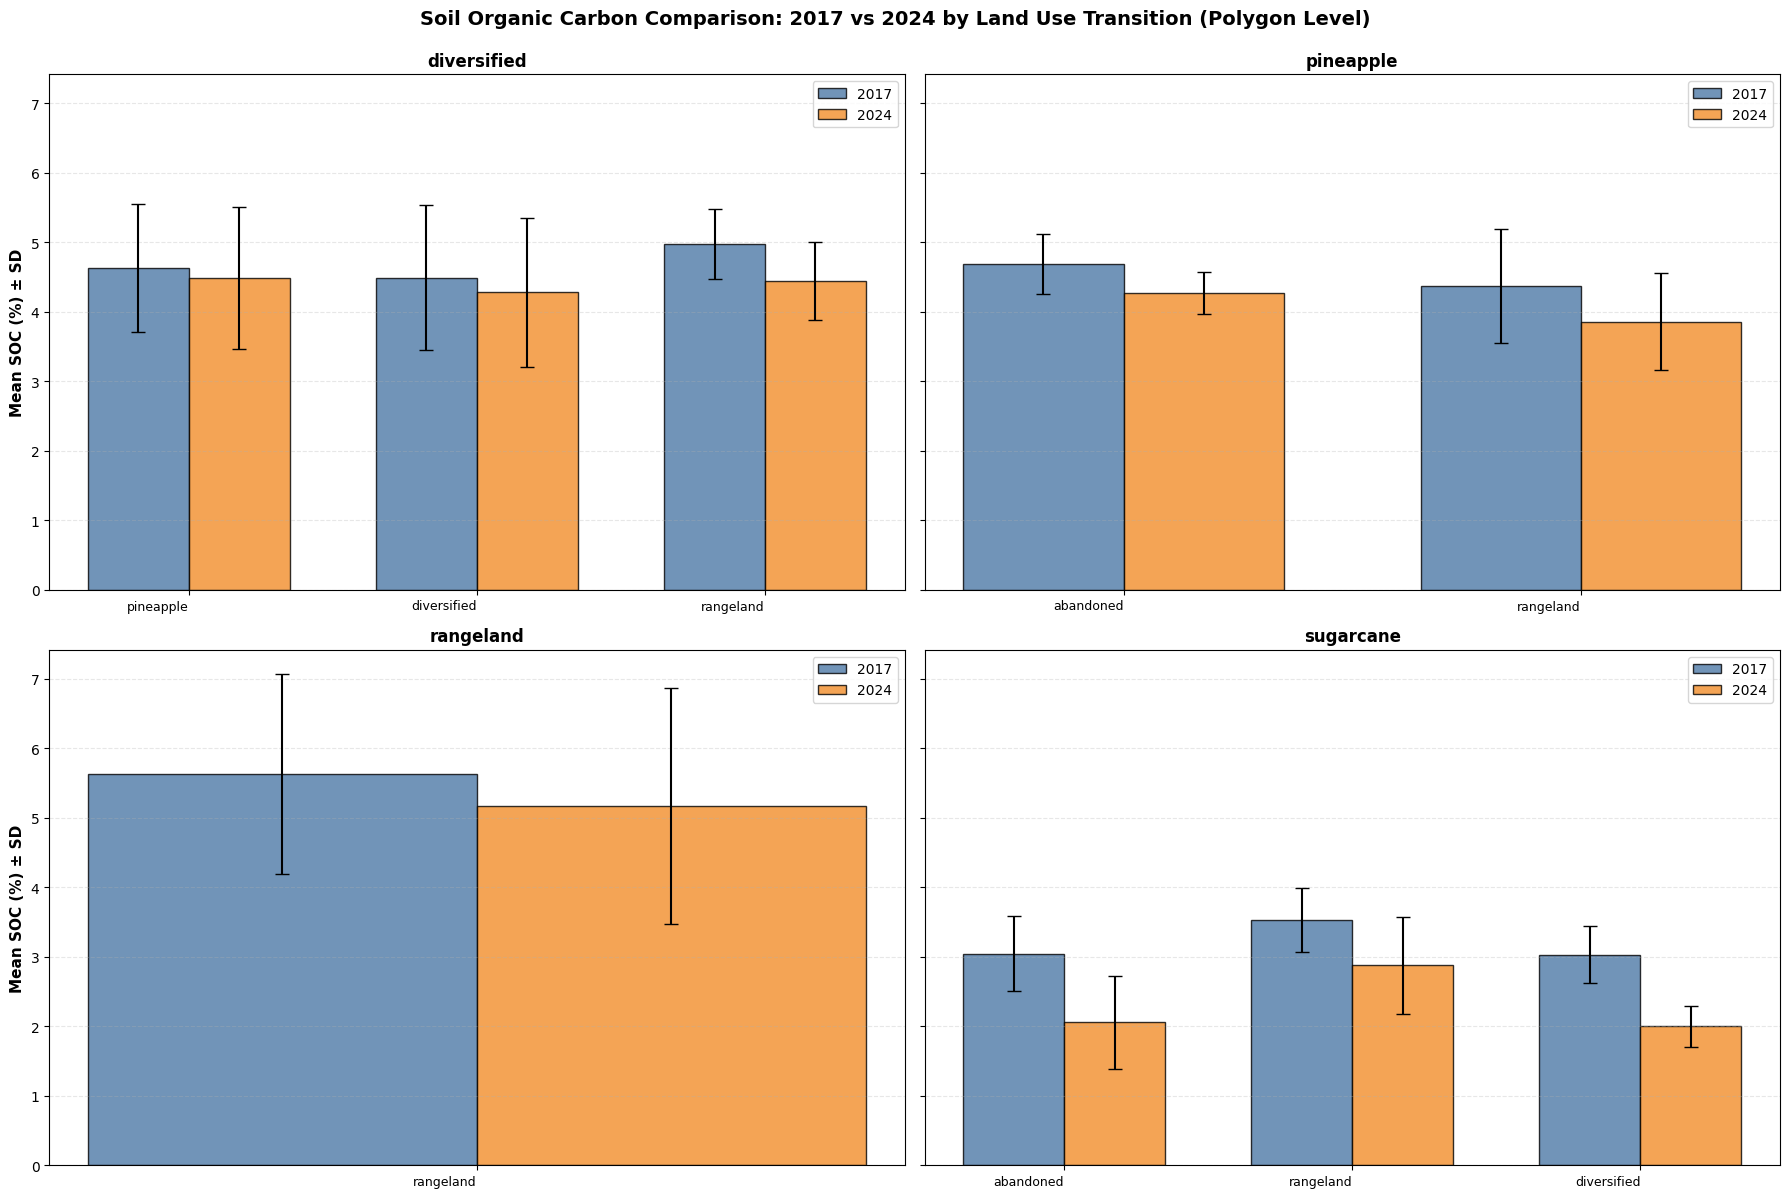

In [70]:
# Create summary data for 2017 and 2024 from polygon_summary_filtered
plot_data = []
for transition in polygon_summary_filtered['land_use_transition'].unique():
    transition_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]
    starting_land_use = transition.split(' → ')[0]

    # Get means and standard deviations from polygon-level data
    soc_2017_mean = transition_data['carbon_first_year'].mean()
    soc_2017_sd = transition_data['carbon_first_year'].std()
    soc_2024_mean = transition_data['carbon_last_year'].mean()
    soc_2024_sd = transition_data['carbon_last_year'].std()

    plot_data.append({
        'starting_land_use': starting_land_use,
        'transition': transition,
        'soc_2017_mean': soc_2017_mean,
        'soc_2017_sd': soc_2017_sd,
        'soc_2024_mean': soc_2024_mean,
        'soc_2024_sd': soc_2024_sd,
        'n_polygons': len(transition_data)
    })

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(['starting_land_use', 'n_polygons'], ascending=[True, False])

# Get unique starting land uses
starting_land_uses = plot_df['starting_land_use'].unique()

# Create subplots - adjust dimensions based on number of starting land uses
n_plots = len(starting_land_uses)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows), sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

for idx, starting_lu in enumerate(starting_land_uses):
    ax = axes[idx]

    # Filter data for this starting land use
    lu_data = plot_df[plot_df['starting_land_use'] == starting_lu]

    # Number of transitions in this group
    n_transitions = len(lu_data)
    x_pos = np.arange(n_transitions)
    width = 0.35

    # Create bars for 2017 and 2024
    bars1 = ax.bar(x_pos - width/2, lu_data['soc_2017_mean'], width,
                   yerr=lu_data['soc_2017_sd'],
                   label='2017', capsize=5, alpha=0.8,
                   color='#4e79a7', edgecolor='black', linewidth=1)

    bars2 = ax.bar(x_pos + width/2, lu_data['soc_2024_mean'], width,
                   yerr=lu_data['soc_2024_sd'],
                   label='2024', capsize=5, alpha=0.8,
                   color='#f28e2b', edgecolor='black', linewidth=1)

    # Customize subplot
    if idx % n_cols == 0:  # Left column
        ax.set_ylabel('Mean SOC (%) ± SD', fontsize=11, fontweight='bold')
    ax.set_title(f'{starting_lu}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)

    # Create labels showing ending state
    labels = [t.split(' → ')[1] for t in lu_data['transition']]
    ax.set_xticklabels(labels, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.legend(loc='upper right', fontsize=10)

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Soil Organic Carbon Comparison: 2017 vs 2024 by Land Use Transition (Polygon Level)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

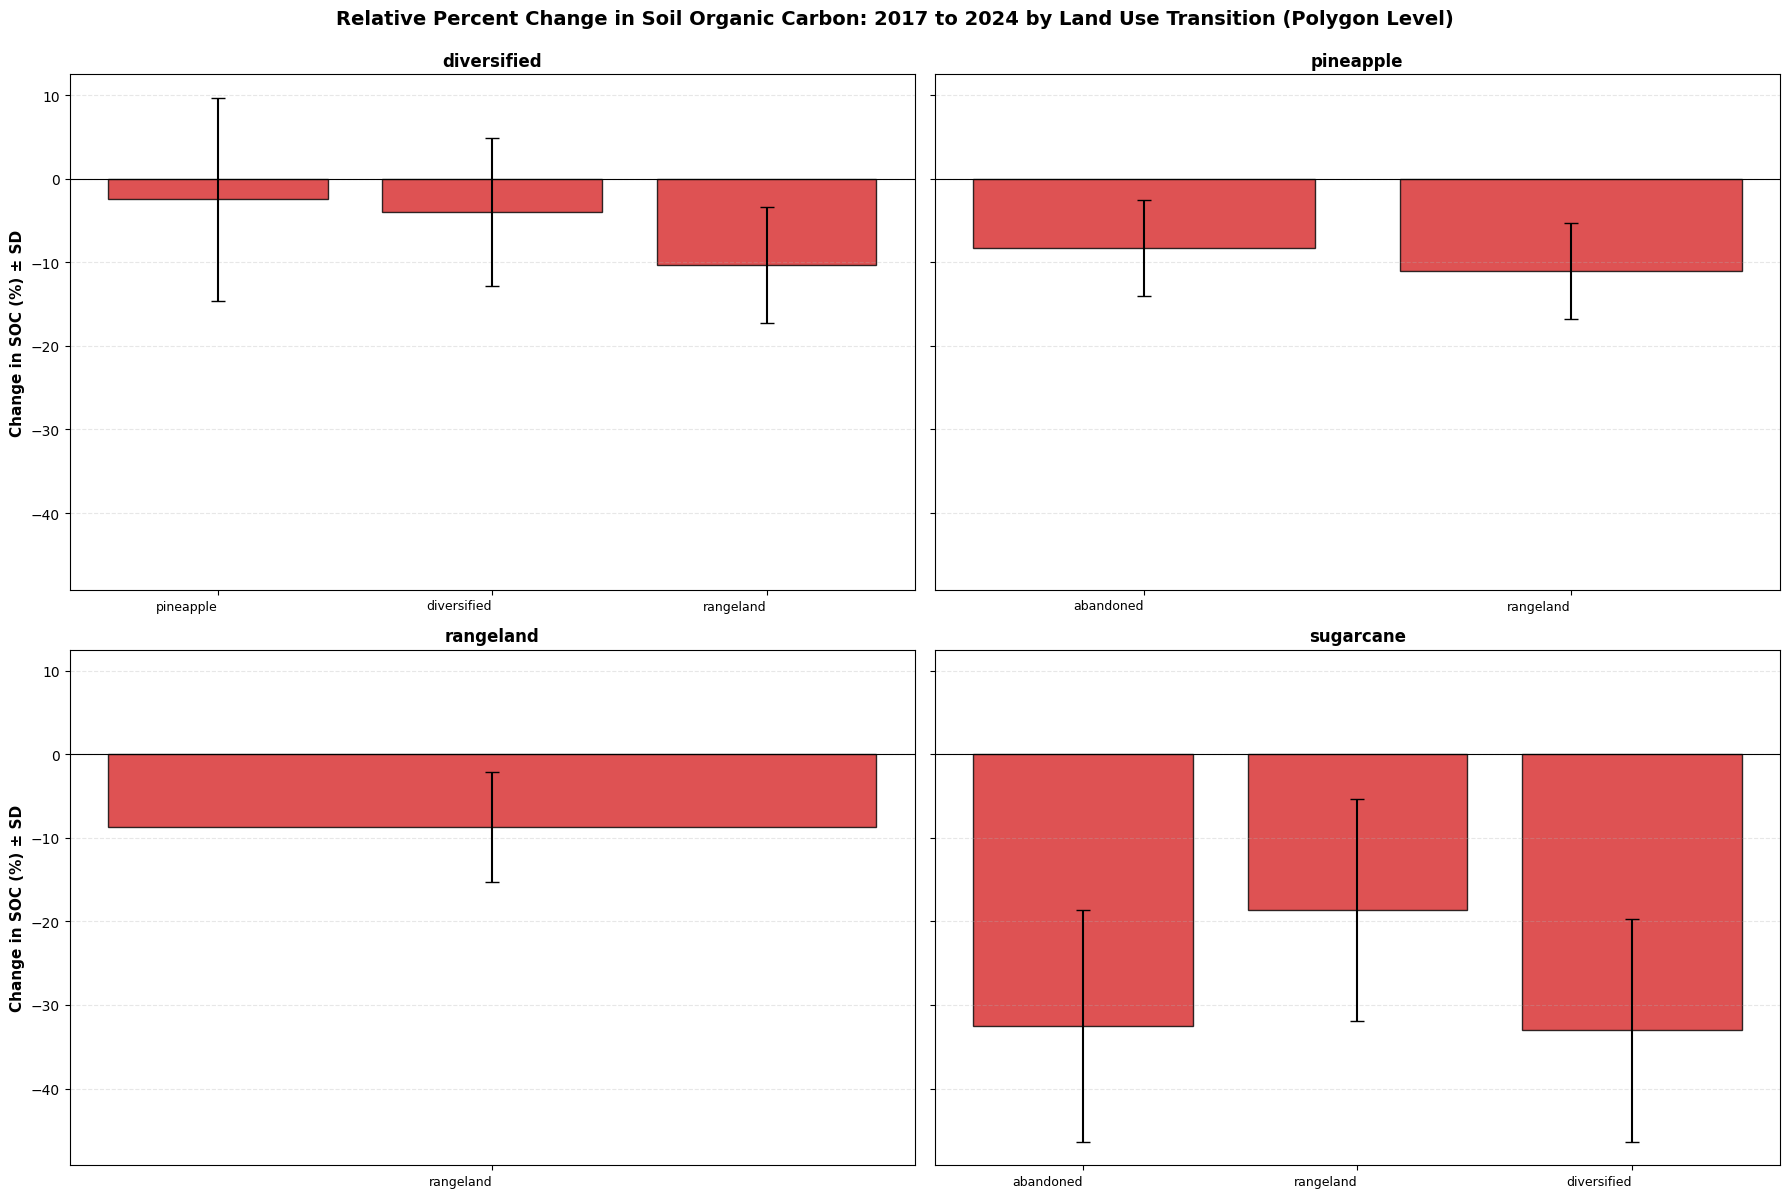

In [71]:
# Create summary data for percent change from 2017 to 2024 from polygon_summary_filtered
plot_data = []
for transition in polygon_summary_filtered['land_use_transition'].unique():
    transition_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]
    starting_land_use = transition.split(' → ')[0]

    # Get percent change statistics from polygon-level data
    pct_change_mean = transition_data['carbon_pct_change'].mean()
    pct_change_sd = transition_data['carbon_pct_change'].std()

    plot_data.append({
        'starting_land_use': starting_land_use,
        'transition': transition,
        'pct_change': pct_change_mean,
        'pct_change_sd': pct_change_sd,
        'n_polygons': len(transition_data)
    })

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(['starting_land_use', 'n_polygons'], ascending=[True, False])

# Get unique starting land uses
starting_land_uses = plot_df['starting_land_use'].unique()

# Create subplots - adjust dimensions based on number of starting land uses
n_plots = len(starting_land_uses)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows), sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

for idx, starting_lu in enumerate(starting_land_uses):
    ax = axes[idx]

    # Filter data for this starting land use
    lu_data = plot_df[plot_df['starting_land_use'] == starting_lu]

    # Number of transitions in this group
    n_transitions = len(lu_data)
    x_pos = np.arange(n_transitions)

    # Color bars based on positive (green) or negative (red) change
    colors = ['#2ca02c' if pct >= 0 else '#d62728' for pct in lu_data['pct_change']]

    # Create bars for percent change with error bars
    bars = ax.bar(x_pos, lu_data['pct_change'],
                  yerr=lu_data['pct_change_sd'],
                  capsize=5,
                  alpha=0.8,
                  color=colors,
                  edgecolor='black', linewidth=1)

    # Add horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Customize subplot
    if idx % n_cols == 0:  # Left column
        ax.set_ylabel('Change in SOC (%) ± SD', fontsize=11, fontweight='bold')
    ax.set_title(f'{starting_lu}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)

    # Create labels showing ending state
    labels = [t.split(' → ')[1] for t in lu_data['transition']]
    ax.set_xticklabels(labels, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Relative Percent Change in Soil Organic Carbon: 2017 to 2024 by Land Use Transition (Polygon Level)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

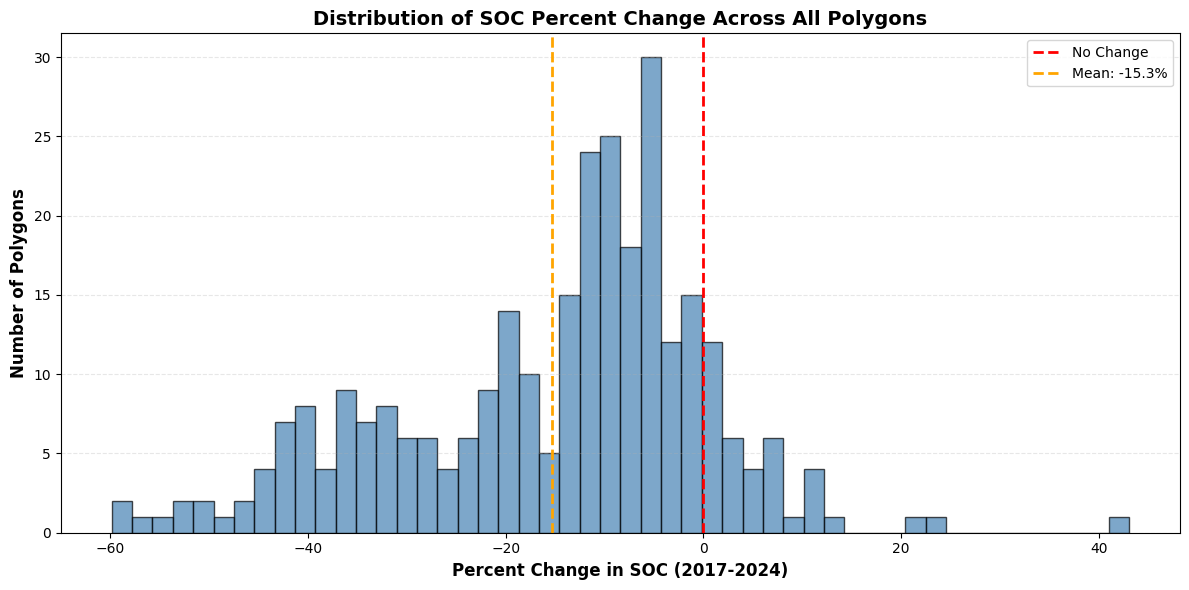

Total unique polygons: 294


/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


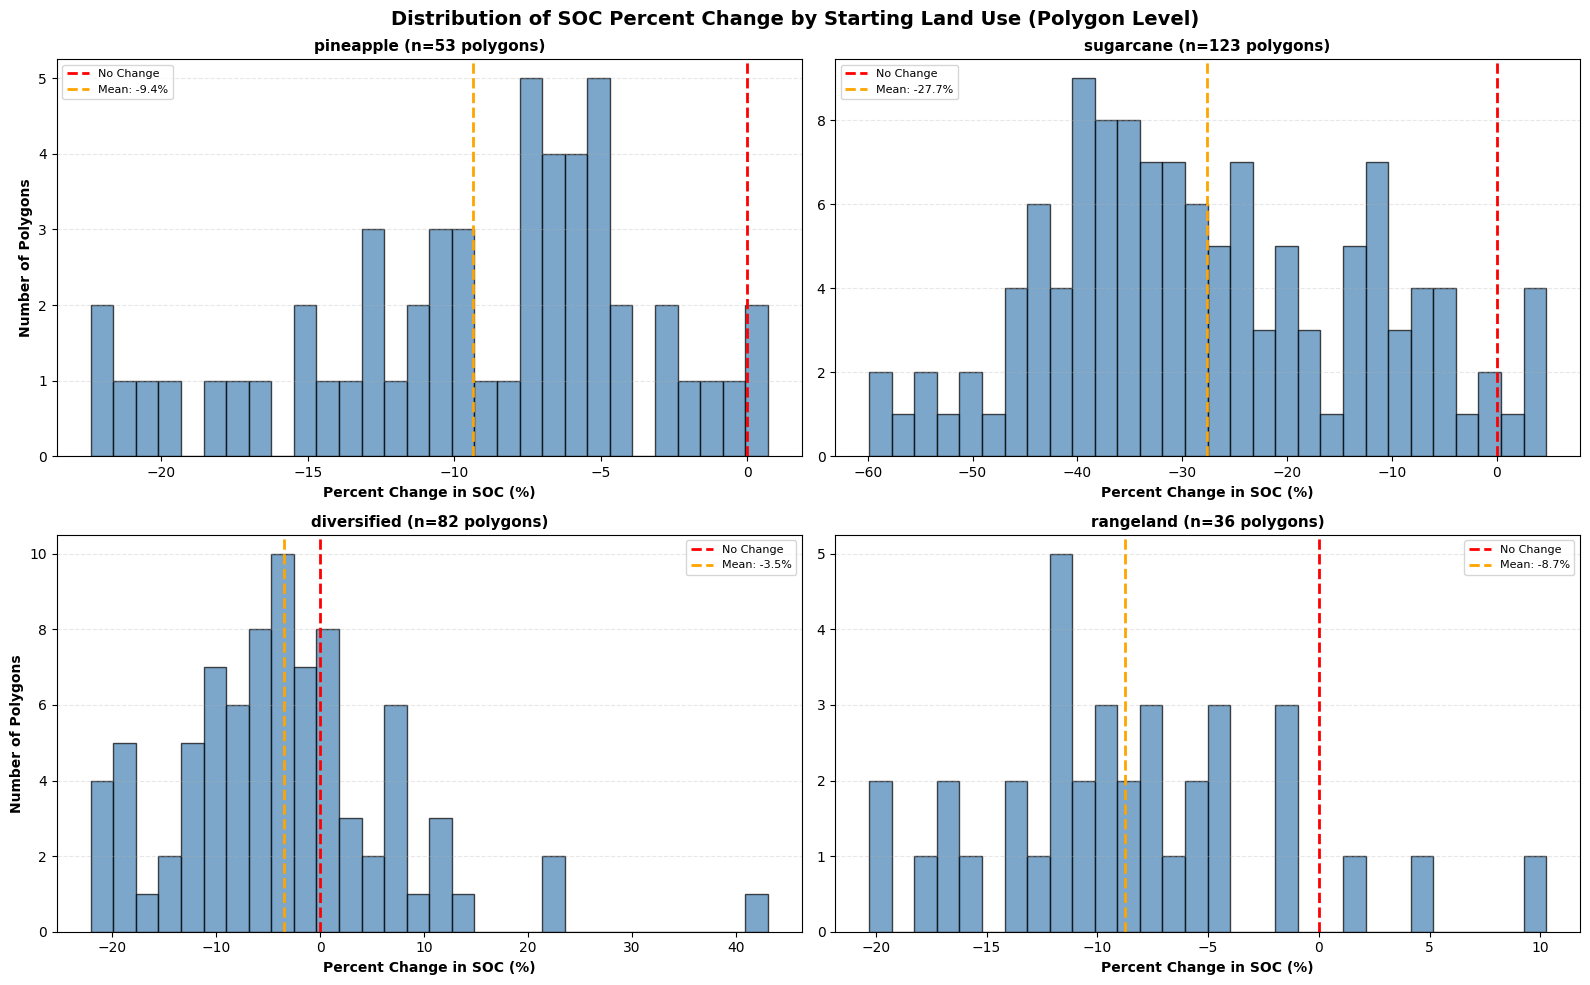

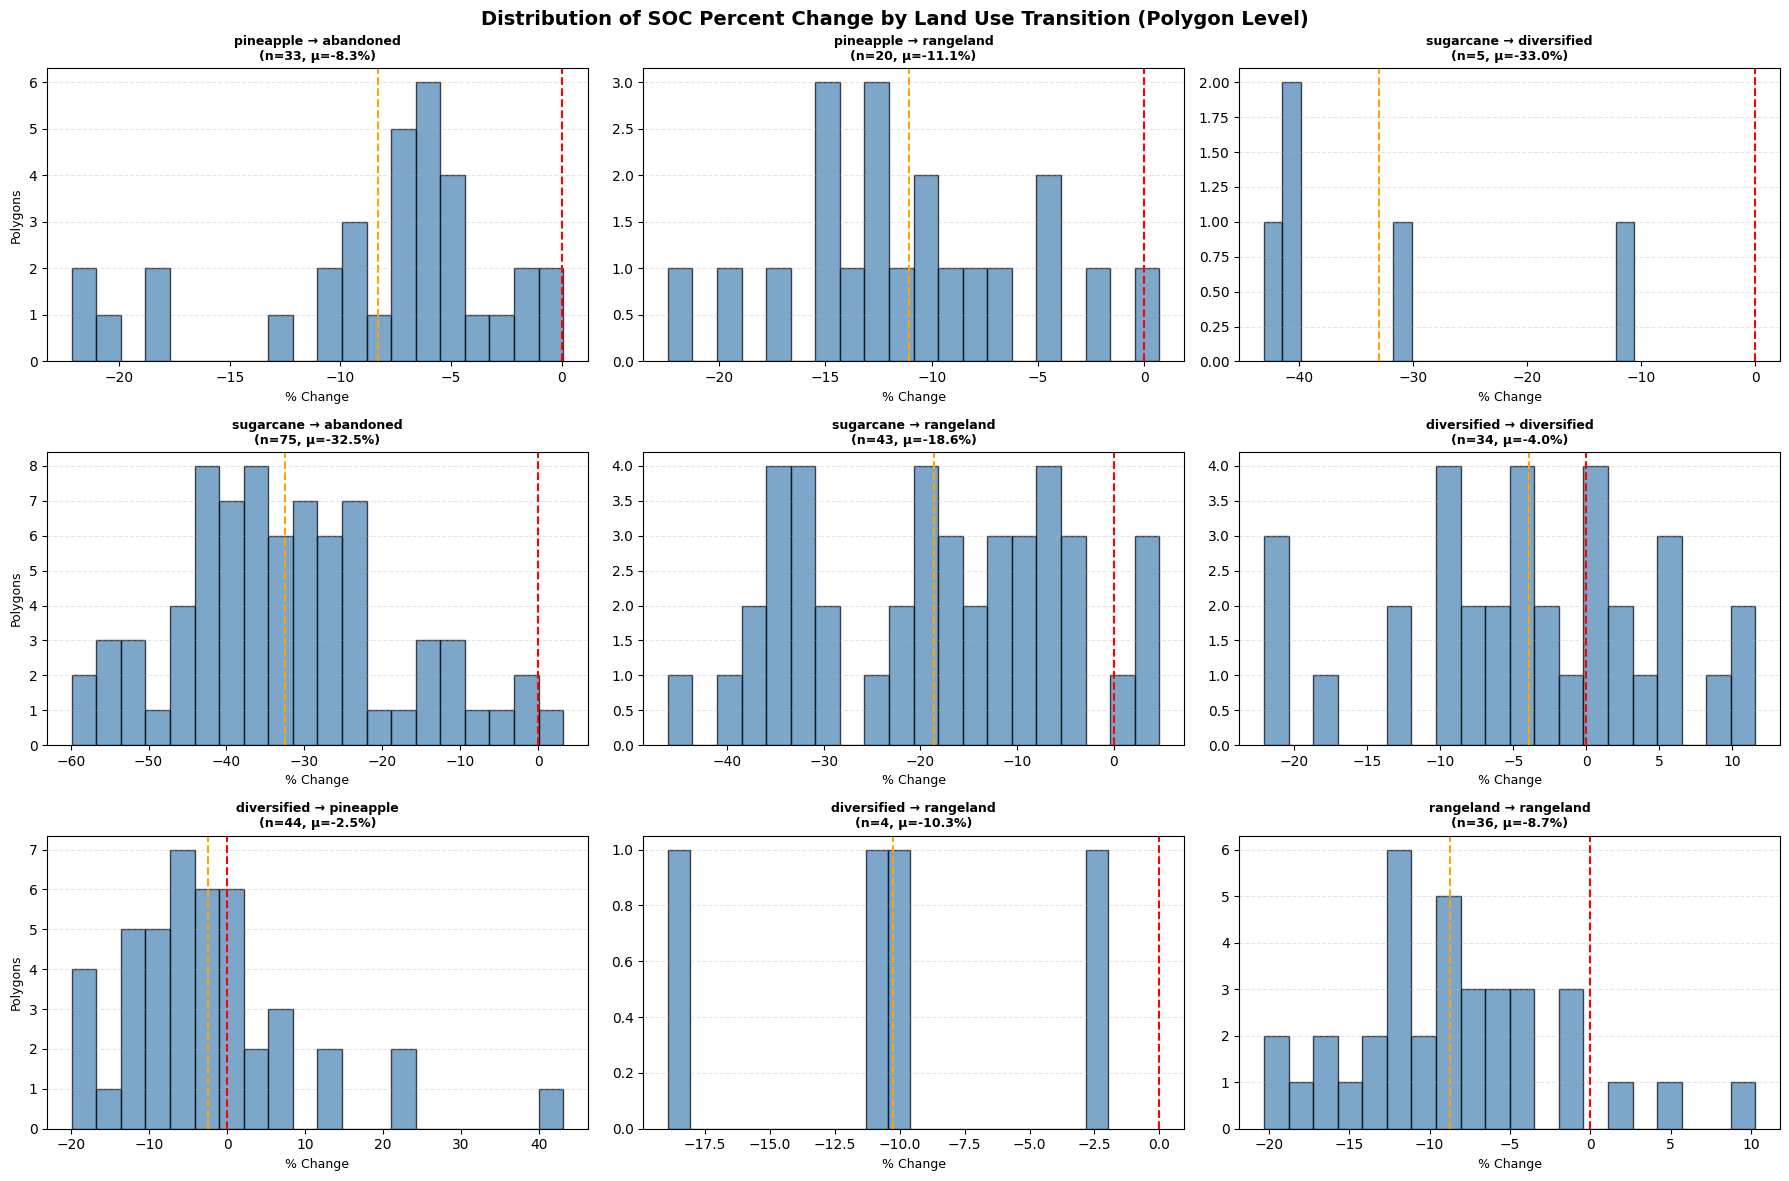

In [72]:
# 1. Overall histogram by polygon
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(polygon_summary_filtered['carbon_pct_change'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
ax.axvline(x=polygon_summary_filtered['carbon_pct_change'].mean(), color='orange', linestyle='--', linewidth=2,
           label=f'Mean: {polygon_summary_filtered["carbon_pct_change"].mean():.1f}%')
ax.set_xlabel('Percent Change in SOC (2017-2024)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Polygons', fontsize=12, fontweight='bold')
ax.set_title('Distribution of SOC Percent Change Across All Polygons', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

print(f"Total unique polygons: {len(polygon_summary_filtered)}")

# 2. Histograms by starting land use
polygon_summary_filtered['starting_land_use'] = polygon_summary_filtered['land_use_transition'].apply(lambda x: x.split(' → ')[0])
starting_land_uses = polygon_summary_filtered['starting_land_use'].unique()

n_plots = len(starting_land_uses)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
axes = axes.flatten()

for idx, starting_lu in enumerate(starting_land_uses):
    ax = axes[idx]

    # Get data for this starting land use
    lu_data = polygon_summary_filtered[polygon_summary_filtered['starting_land_use'] == starting_lu]

    # Create histogram
    ax.hist(lu_data['carbon_pct_change'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
    ax.axvline(x=lu_data['carbon_pct_change'].mean(), color='orange', linestyle='--', linewidth=2,
               label=f'Mean: {lu_data["carbon_pct_change"].mean():.1f}%')

    ax.set_xlabel('Percent Change in SOC (%)', fontsize=10, fontweight='bold')
    if idx % n_cols == 0:
        ax.set_ylabel('Number of Polygons', fontsize=10, fontweight='bold')
    ax.set_title(f'{starting_lu} (n={len(lu_data)} polygons)', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of SOC Percent Change by Starting Land Use (Polygon Level)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Histograms by specific transition (all transitions)
transitions = polygon_summary_filtered['land_use_transition'].unique()
n_plots = len(transitions)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for idx, transition in enumerate(transitions):
    ax = axes[idx]

    # Get data for this transition
    trans_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]

    # Create histogram
    ax.hist(trans_data['carbon_pct_change'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax.axvline(x=trans_data['carbon_pct_change'].mean(), color='orange', linestyle='--', linewidth=1.5)

    ax.set_xlabel('% Change', fontsize=9)
    if idx % n_cols == 0:
        ax.set_ylabel('Polygons', fontsize=9)
    ax.set_title(f'{transition}\n(n={len(trans_data)}, μ={trans_data["carbon_pct_change"].mean():.1f}%)',
                 fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of SOC Percent Change by Land Use Transition (Polygon Level)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

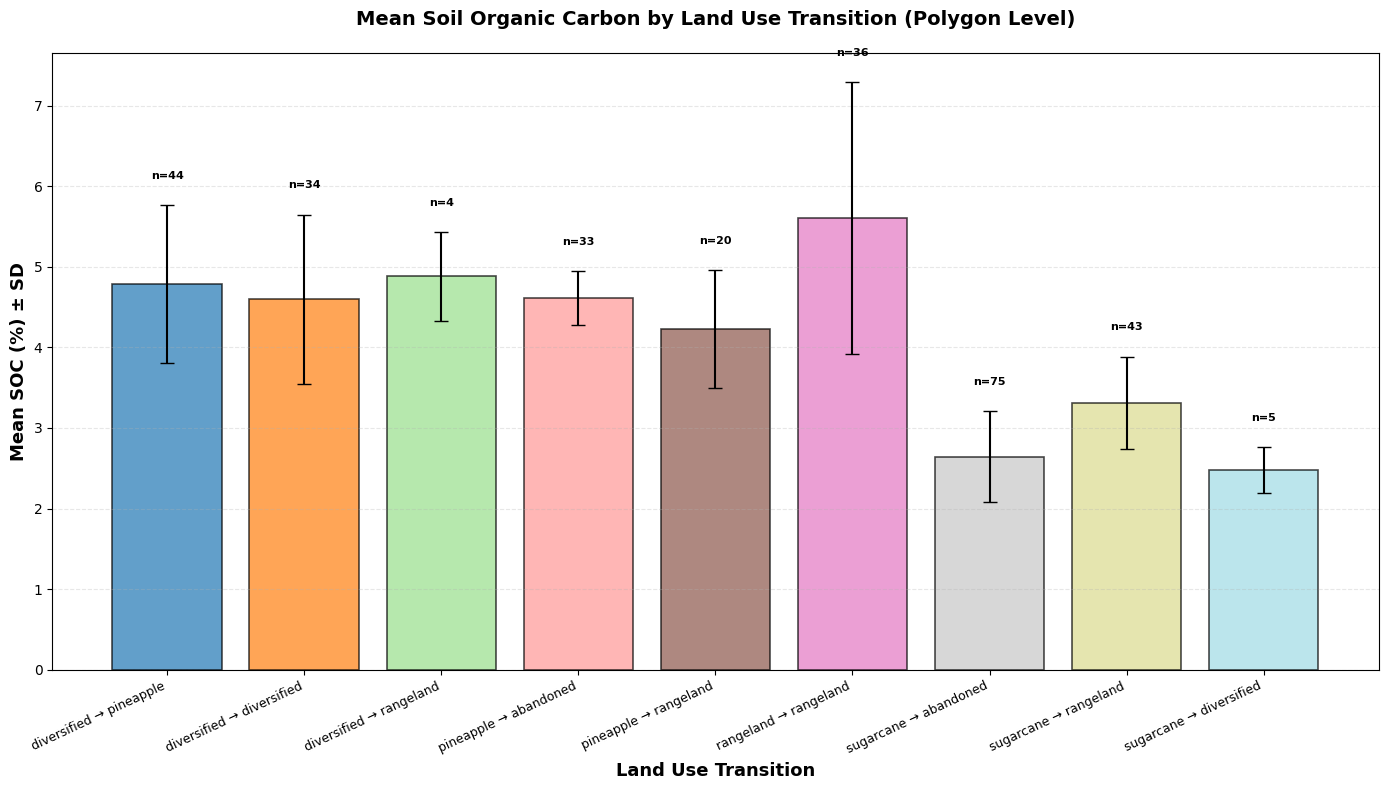

In [73]:
# Create summary data for bar plot from polygon_summary_filtered
summary_data = []

for transition in polygon_summary_filtered['land_use_transition'].unique():
    transition_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]

    # Get mean and std from polygon-level data
    mean_soc = transition_data['carbon_mean'].mean()
    std_soc = transition_data['carbon_mean'].std()

    # Extract starting land use
    starting_land_use = transition.split(' → ')[0]

    summary_data.append({
        'starting_land_use': starting_land_use,
        'transition': transition,
        'n_polygons': len(transition_data),
        'mean_soc': mean_soc,
        'std_soc': std_soc
    })

# Create DataFrame and sort by starting land use, then by number of polygons
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['starting_land_use', 'n_polygons'], ascending=[True, False])

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Create bar positions
x_pos = np.arange(len(summary_df))

# Create bars with error bars
bars = ax.bar(x_pos, summary_df['mean_soc'],
              yerr=summary_df['std_soc'],
              capsize=5,
              alpha=0.7,
              color=plt.cm.tab20(np.linspace(0, 1, len(summary_df))),
              edgecolor='black',
              linewidth=1.2)

# Customize the plot
ax.set_xlabel('Land Use Transition', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%) ± SD', fontsize=13, fontweight='bold')
ax.set_title('Mean Soil Organic Carbon by Land Use Transition (Polygon Level)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(summary_df['transition'], rotation=25, ha='right', fontsize=9)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add sample size annotations on top of bars
for i, (idx, row) in enumerate(summary_df.iterrows()):
    ax.text(i, row['mean_soc'] + row['std_soc'] + 0.3,
            f"n={row['n_polygons']}",
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

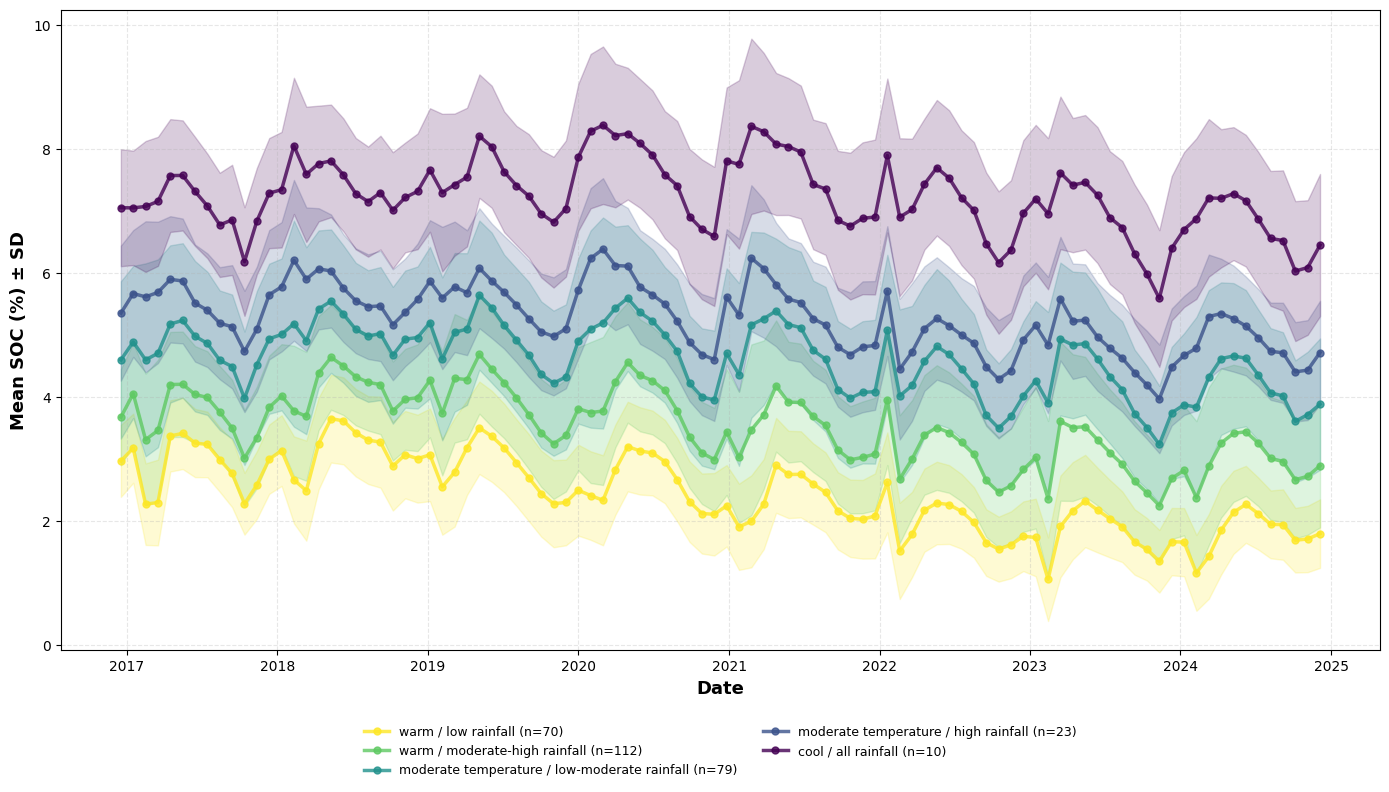

In [76]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Get all the monthly carbon columns
date_cols = [col for col in df.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Define the order for climate bins with fixed colors
climate_order = [
    'warm / low rainfall',
    'warm / moderate-high rainfall',
    'moderate temperature / low-moderate rainfall',
    'moderate temperature / high rainfall',
    'cool / all rainfall'
]

# Create a color map for all climate bins
all_colors = plt.cm.viridis(np.linspace(1, 0, len(climate_order)))
color_map = {climate: all_colors[i] for i, climate in enumerate(climate_order)}

# Filter to only climate bins that exist in polygon_summary_filtered
climate_bins = [c for c in climate_order if c in polygon_summary_filtered['climate_description'].values]

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot for each climate bin
for climate in climate_bins:
    # Get polygon IDs for this climate bin
    polygon_ids = polygon_summary_filtered[polygon_summary_filtered['climate_description'] == climate]['polygonid']

    # Filter original df data for these polygons
    climate_data = df[df['polygonid'].isin(polygon_ids)]

    # Calculate mean and std for each date
    yearly_means = []
    yearly_stds = []
    for date_col in date_cols:
        yearly_means.append(climate_data[date_col].mean())
        yearly_stds.append(climate_data[date_col].std())

    yearly_means = np.array(yearly_means)
    yearly_stds = np.array(yearly_stds)

    # Plot line using the fixed color from color_map
    ax.plot(dates, yearly_means,
            marker='o', linewidth=2.5, markersize=5,
            label=f'{climate} (n={len(polygon_ids)})',
            color=color_map[climate], alpha=0.8)

    # Add shaded standard deviation
    ax.fill_between(dates,
                    yearly_means - yearly_stds,
                    yearly_means + yearly_stds,
                    color=color_map[climate], alpha=0.2)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%) ± SD', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

# Move legend below x-axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fontsize=9, ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [77]:
# Print summary statistics
print("\n" + "="*80)
print("CLIMATE BIN SUMMARY - PREDICTED CARBON (POLYGON LEVEL)")
print("="*80)

for climate in climate_bins:
    climate_polygons = polygon_summary_filtered[polygon_summary_filtered['climate_description'] == climate]
    print(f"\n{climate}:")
    print(f"  Number of polygons: {len(climate_polygons)}")
    print(f"  Mean SOC: {climate_polygons['carbon_mean'].mean():.2f} ± {climate_polygons['carbon_mean'].std():.2f}%")
    print(f"  First year ({first_year}) mean: {climate_polygons['carbon_first_year'].mean():.2f}%")
    print(f"  Last year ({last_year}) mean: {climate_polygons['carbon_last_year'].mean():.2f}%")
    print(f"  Change from {first_year} to {last_year}: {climate_polygons['carbon_change'].mean():+.2f}% ({climate_polygons['carbon_pct_change'].mean():+.1f}%)")


CLIMATE BIN SUMMARY - PREDICTED CARBON (POLYGON LEVEL)

warm / low rainfall:
  Number of polygons: 70
  Mean SOC: 2.47 ± 0.35%
  First year (2017) mean: 2.92%
  Last year (2024) mean: 1.92%
  Change from 2017 to 2024: -1.00% (-33.8%)

warm / moderate-high rainfall:
  Number of polygons: 112
  Mean SOC: 3.91 ± 0.75%
  First year (2017) mean: 4.05%
  Last year (2024) mean: 3.51%
  Change from 2017 to 2024: -0.54% (-13.7%)

moderate temperature / low-moderate rainfall:
  Number of polygons: 79
  Mean SOC: 4.79 ± 0.97%
  First year (2017) mean: 4.71%
  Last year (2024) mean: 4.41%
  Change from 2017 to 2024: -0.30% (-5.4%)

moderate temperature / high rainfall:
  Number of polygons: 23
  Mean SOC: 5.14 ± 0.84%
  First year (2017) mean: 5.21%
  Last year (2024) mean: 4.80%
  Change from 2017 to 2024: -0.41% (-7.3%)

cool / all rainfall:
  Number of polygons: 10
  Mean SOC: 7.00 ± 2.45%
  First year (2017) mean: 6.59%
  Last year (2024) mean: 6.64%
  Change from 2017 to 2024: +0.05% (+0.4%)

In [79]:
for col in df.columns:
    print(col)

id
lat
lon
lat_lon_id
landsat_9_unique_locs_id
landsat_9_unique_locs_min_dis
landsat_8_unique_locs_id
landsat_8_unique_locs_min_dis
landsat_7_unique_locs_id
landsat_7_unique_locs_min_dis
landsat_5_unique_locs_id
landsat_5_unique_locs_min_dis
terrain_SRTM_unique_locs_id
terrain_SRTM_unique_locs_min_dis
terrain_aspect_unique_locs_id
terrain_aspect_unique_locs_min_dis
terraclimate_unique_locs_id
terraclimate_unique_locs_min_dis
terrain_elevation_unique_locs_id
terrain_elevation_unique_locs_min_dis
terrain_slope_unique_locs_id
terrain_slope_unique_locs_min_dis
d_20161217
d_20170116
d_20170215
d_20170317
d_20170416
d_20170516
d_20170615
d_20170715
d_20170814
d_20170913
d_20171013
d_20171112
d_20171212
d_20180111
d_20180210
d_20180312
d_20180411
d_20180511
d_20180610
d_20180710
d_20180809
d_20180908
d_20181008
d_20181107
d_20181207
d_20190106
d_20190205
d_20190307
d_20190406
d_20190506
d_20190605
d_20190705
d_20190804
d_20190903
d_20191003
d_20191102
d_20191202
d_20200101
d_20200131
d_202003

Found 11 unique soil suborders


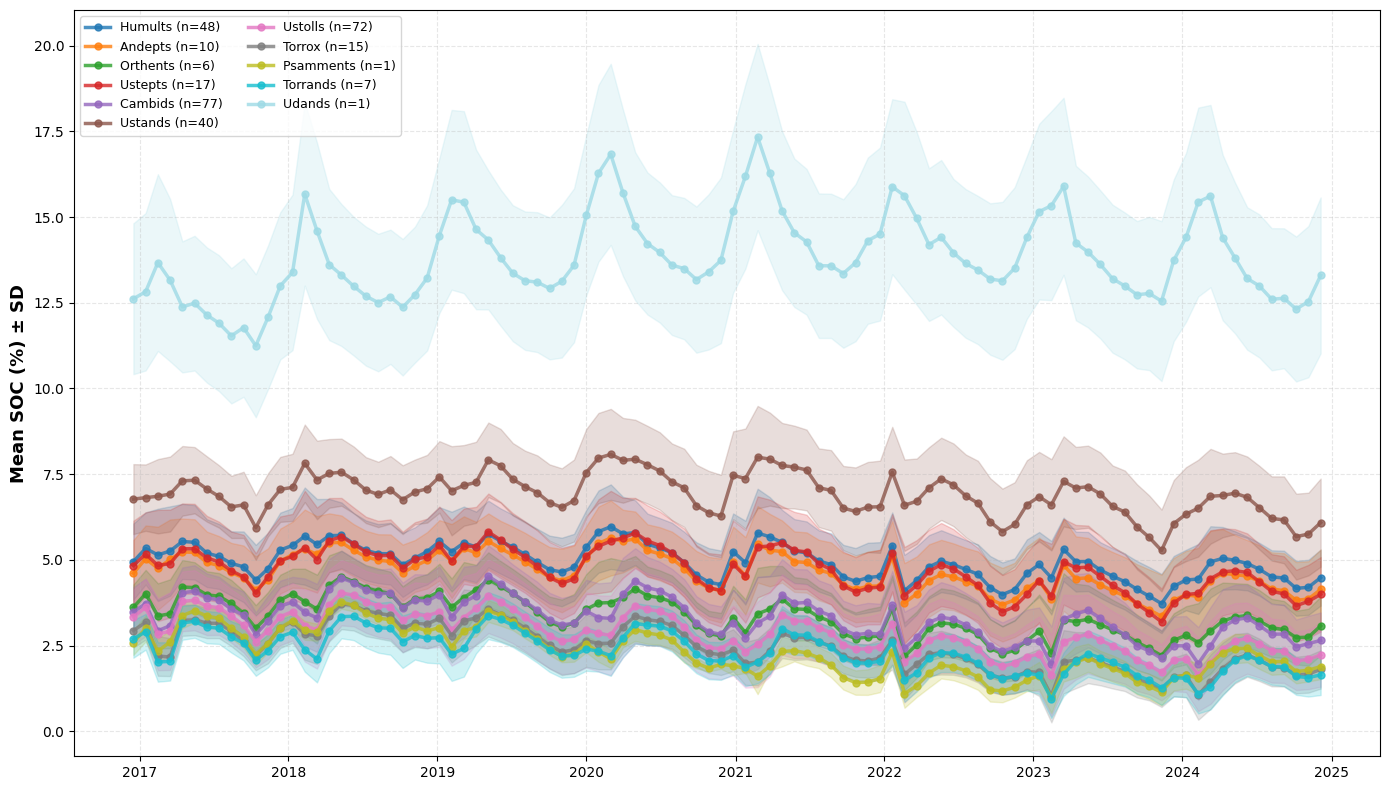

In [83]:
# Get all the monthly carbon columns
date_cols = [col for col in df.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Get unique soil suborders from polygon_summary_filtered
suborders = polygon_summary_filtered['Suborder'].unique()
print(f"Found {len(suborders)} unique soil suborders")

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors for each suborder
colors = plt.cm.tab20(np.linspace(0, 1, len(suborders)))

# Plot for each soil suborder
for idx, suborder in enumerate(suborders):
    # Get polygon IDs for this suborder
    polygon_ids = polygon_summary_filtered[polygon_summary_filtered['Suborder'] == suborder]['polygonid']

    # Filter original df data for these polygons
    suborder_data = df[df['polygonid'].isin(polygon_ids)]

    # Calculate mean and std for each date
    yearly_means = []
    yearly_stds = []
    for date_col in date_cols:
        yearly_means.append(suborder_data[date_col].mean())
        yearly_stds.append(suborder_data[date_col].std())

    yearly_means = np.array(yearly_means)
    yearly_stds = np.array(yearly_stds)

    # Plot line
    ax.plot(dates, yearly_means,
            marker='o', linewidth=2.5, markersize=5,
            label=f'{suborder} (n={len(polygon_ids)})',
            color=colors[idx], alpha=0.8)

    # Add shaded standard deviation
    ax.fill_between(dates,
                    yearly_means - yearly_stds,
                    yearly_means + yearly_stds,
                    color=colors[idx], alpha=0.2)

ax.set_ylabel('Mean SOC (%) ± SD', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

In [84]:
# Print summary statistics
print("\n" + "="*80)
print("SOIL SUBORDER SUMMARY - PREDICTED CARBON (POLYGON LEVEL)")
print("="*80)

for suborder in sorted(suborders):
    suborder_polygons = polygon_summary_filtered[polygon_summary_filtered['Suborder'] == suborder]
    print(f"\n{suborder}:")
    print(f"  Number of polygons: {len(suborder_polygons)}")
    print(f"  Mean SOC: {suborder_polygons['carbon_mean'].mean():.2f} ± {suborder_polygons['carbon_mean'].std():.2f}%")
    print(f"  First year ({first_year}) mean: {suborder_polygons['carbon_first_year'].mean():.2f}%")
    print(f"  Last year ({last_year}) mean: {suborder_polygons['carbon_last_year'].mean():.2f}%")
    print(f"  Change from {first_year} to {last_year}: {suborder_polygons['carbon_change'].mean():+.2f}% ({suborder_polygons['carbon_pct_change'].mean():+.1f}%)")


SOIL SUBORDER SUMMARY - PREDICTED CARBON (POLYGON LEVEL)

Andepts:
  Number of polygons: 10
  Mean SOC: 4.72 ± 0.59%
  First year (2017) mean: 4.82%
  Last year (2024) mean: 4.35%
  Change from 2017 to 2024: -0.47% (-10.1%)

Cambids:
  Number of polygons: 77
  Mean SOC: 3.78 ± 0.84%
  First year (2017) mean: 3.83%
  Last year (2024) mean: 3.38%
  Change from 2017 to 2024: -0.45% (-11.8%)

Humults:
  Number of polygons: 48
  Mean SOC: 4.55 ± 0.56%
  First year (2017) mean: 4.64%
  Last year (2024) mean: 4.29%
  Change from 2017 to 2024: -0.35% (-6.9%)

Orthents:
  Number of polygons: 6
  Mean SOC: 3.63 ± 0.89%
  First year (2017) mean: 3.96%
  Last year (2024) mean: 3.21%
  Change from 2017 to 2024: -0.75% (-19.9%)

Psamments:
  Number of polygons: 1
  Mean SOC: 2.31 ± nan%
  First year (2017) mean: 2.92%
  Last year (2024) mean: 2.00%
  Change from 2017 to 2024: -0.92% (-31.4%)

Torrands:
  Number of polygons: 7
  Mean SOC: 2.34 ± 0.32%
  First year (2017) mean: 2.77%
  Last year (202

In [86]:
# Load measured SOC data
measured = gpd.read_file('/content/Maui_0_20_subregion_measured-6.gpkg')

measured = measured.rename(columns={'1': 'climate_bin'})

In [89]:
# Define climate bins
bin_descriptions = {
    1: "cool / all rainfall",
    10: "moderate temperature / low-moderate rainfall",
    11: "moderate temperature / high rainfall",
    20: "warm / low rainfall",
    21: "warm / moderate-high rainfall"
}

# Map the descriptions to a new column
measured['climate_description'] = measured['climate_bin'].map(bin_descriptions)

# # Check the result
# print(measured[['climate_bin', 'climate_description']].head(50))

In [90]:
# Summary stats
summary_by_year = measured.groupby('year_sampled')['imp_c_perc'].describe()
print("Detailed Summary Statistics:")
display(summary_by_year)

Detailed Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
year_sampled,,,,,,,,
1963,1.0,15.700000,NaN,15.700000,15.700000,15.700000,15.700000,15.700000
1965,1.0,1.850000,NaN,1.850000,1.850000,1.850000,1.850000,1.850000
1983,8.0,5.852500,3.950507,1.450000,2.707500,5.010000,9.595000,11.480000
1989,1.0,4.740000,NaN,4.740000,4.740000,4.740000,4.740000,4.740000
1997,4.0,7.165000,2.642858,5.250000,5.812500,6.170000,7.522500,11.070000
1998,3.0,10.273333,4.861094,6.540000,7.525000,8.510000,12.140000,15.770000
2001,1.0,0.970000,NaN,0.970000,0.970000,0.970000,0.970000,0.970000
2011,41.0,1.595854,0.266458,1.200000,1.400000,1.500000,1.790000,2.250000
2012,11.0,1.650909,0.294600,1.260000,1.400000,1.620000,1.830000,2.130000


In [91]:
# Pivot table - mean by year and suborder
pivot_mean = measured.pivot_table(
    values='imp_c_perc',
    index='Suborder',
    columns='year_sampled',
    aggfunc='mean'
).round(2)

# Replace NaN with dash for display
pivot_display = pivot_mean.fillna('-')

display(pivot_display)

year_sampled,1963,1965,1983,1989,1997,1998,2001,2011,2012,2013,2014,2017,2018,2019,2022,2023,2024,2025
Suborder,,,,,,,,,,,,,,,,,,
Andepts,-,-,-,-,-,-,-,-,-,-,-,9.56,-,-,-,-,-,-
Aquepts,-,-,-,-,-,6.54,-,-,-,-,-,-,-,-,-,-,-,-
Cambids,-,-,5.03,-,-,-,-,1.39,1.4,1.35,1.4,-,-,-,1.1,1.08,0.81,-
Humults,-,-,3.1,4.74,-,-,-,-,-,-,-,-,2.43,-,1.7,1.66,6.37,-
Orthents,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.05,-
Torrox,-,-,1.53,-,-,-,-,1.61,1.64,1.65,1.7,-,-,-,-,-,-,-
Udands,-,-,-,-,7.16,-,-,-,-,-,-,12.55,30.6,-,12.2,-,16.07,-
Ustands,15.7,-,9.03,-,-,12.14,-,1.38,1.34,1.32,1.37,9.58,13.1,-,12.35,7.22,13.54,16.15
Ustepts,-,-,-,-,-,-,0.97,-,-,-,-,6.59,4.45,-,4.53,4.44,-,-


In [92]:
# Pivot table - mean by year and climate bin
pivot_mean = measured.pivot_table(
    values='imp_c_perc',
    index='climate_description',
    columns='year_sampled',
    aggfunc='mean'
).round(2)

# Replace NaN with dash for display
pivot_display = pivot_mean.fillna('-')

display(pivot_display)

year_sampled,1963,1965,1983,1989,1997,1998,2001,2011,2012,2013,2014,2017,2018,2019,2022,2023,2024,2025
climate_description,,,,,,,,,,,,,,,,,,
cool / all rainfall,15.7,-,10.52,-,7.16,10.27,-,-,-,-,-,10.6,17.48,-,12.71,7.09,14.33,16.15
moderate temperature / high rainfall,-,-,3.1,4.74,-,-,-,-,-,-,-,6.99,-,-,2.82,2.77,6.21,-
moderate temperature / low-moderate rainfall,-,-,5.28,-,-,-,0.97,1.38,1.34,1.32,1.37,7.95,4.65,-,5.73,4.22,1.05,-
warm / low rainfall,-,-,-,-,-,-,-,1.76,1.82,1.74,1.81,-,-,-,-,-,-,-
warm / moderate-high rainfall,-,1.85,1.53,-,-,-,-,1.39,1.4,1.35,1.4,-,1.84,1.58,2.28,2.24,0.81,-


In [93]:
# Summary by climate bin and year
summary_by_climate_year = measured.groupby(['climate_description', 'year_sampled'])['imp_c_perc'].describe()
print("Detailed Summary Statistics by Climate and Year:")
display(summary_by_climate_year)

Detailed Summary Statistics by Climate and Year:


count       mean  \
climate_description                          year_sampled                     
cool / all rainfall                          1963            1.0  15.700000   
                                             1983            2.0  10.525000   
                                             1997            4.0   7.165000   
                                             1998            3.0  10.273333   
                                             2017          137.0  10.596350   
                                             2018           12.0  17.477956   
                                             2022           39.0  12.708230   
                                             2023            1.0   7.094750   
                                             2024           26.0  14.325760   
                                             2025           10.0  16.149575   
moderate temperature / high rainfall         1983            1.0   3.100000   
                                             1989            1.0   4.740000   
                                             2017            9.0   6.987778   
                                             2022            2.0   2.818974   
                                             2023            2.0   2.765750   
                                             2024            4.0   6.213687   
moderate temperature / low-moderate rainfall 1983            4.0   5.285000   
                                             2001            1.0   0.970000   
                                             2011            7.0   1.378571   
                                             2012            3.0   1.343333   
                                             2013            3.0   1.320000   
                                             2014            3.0   1.366667   
                                             2017           58.0   7.948448   
                                             2018            9.0   4.648008   
                                             2022            4.0   5.727515   
                                             2023            2.0   4.218000   
                                             2024            1.0   1.054500   
warm / low rainfall                          2011           23.0   1.762174   
                                             2012            7.0   1.818571   
                                             2013            9.0   1.736667   
                                             2014            9.0   1.812222   
warm / moderate-high rainfall                1965            1.0   1.850000   
                                             1983            1.0   1.530000   
                                             2011           11.0   1.386364   
                                             2012            1.0   1.400000   
                                             2013            1.0   1.350000   
                                             2014            1.0   1.400000   
                                             2018            3.0   1.838462   
                                             2019            6.0   1.576049   
                                             2022            1.0   2.281578   
                                             2023            1.0   2.238500   
                                             2024            1.0   0.814000   

                                                                std  \
climate_description                          year_sampled             
cool / all rainfall                          1963               NaN   
                                             1983          1.350574   
                                             1997          2.642858   
                                             1998          4.861094   
                                             2017          2.217771   
                                             2018          9.235950   
              

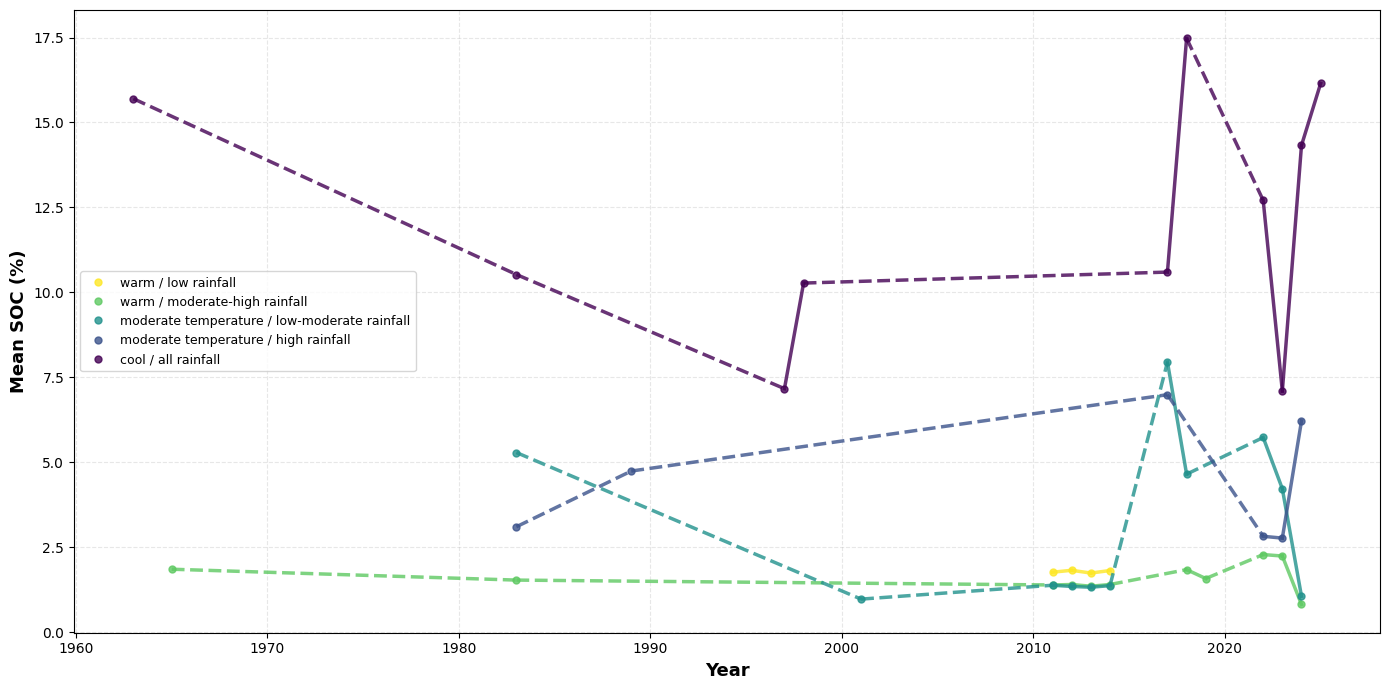

In [96]:
# Define the order for climate bins
climate_order = [
    'warm / low rainfall',
    'warm / moderate-high rainfall',
    'moderate temperature / low-moderate rainfall',
    'moderate temperature / high rainfall',
    'cool / all rainfall'
]

# Create a color map for all climate bins
all_colors = plt.cm.viridis(np.linspace(1, 0, len(climate_order)))
color_map = {climate: all_colors[i] for i, climate in enumerate(climate_order)}

# Filter to only climate bins that exist in the data
climate_bins = [c for c in climate_order if c in measured['climate_description'].values]

# Get unique years
years = sorted(measured['year_sampled'].unique())

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot for each climate bin
for idx, climate in enumerate(climate_bins):
    # Filter data for this climate bin
    climate_data = measured[measured['climate_description'] == climate]

    # Get years with data for this climate bin
    climate_years = sorted(climate_data['year_sampled'].unique())

    # Calculate mean for each year that has data
    yearly_means = []
    for year in climate_years:
        year_data = climate_data[climate_data['year_sampled'] == year]['imp_c_perc']
        yearly_means.append(year_data.mean())

    # Plot with segments - solid where continuous, dashed where gaps
    for i in range(len(climate_years) - 1):
        year_start = climate_years[i]
        year_end = climate_years[i + 1]

        # Check if years are consecutive
        if year_end - year_start == 1:
            # Solid line for consecutive years
            ax.plot([year_start, year_end],
                   [yearly_means[i], yearly_means[i + 1]],
                   color=color_map[climate], linewidth=2.5, alpha=0.8,
                   linestyle='-')
        else:
            # Dashed line for gaps
            ax.plot([year_start, year_end],
                   [yearly_means[i], yearly_means[i + 1]],
                   color=color_map[climate], linewidth=2.5, alpha=0.8,
                   linestyle='--')

    # Plot markers
    ax.plot(climate_years, yearly_means,
            marker='o', markersize=5,
            color=color_map[climate], alpha=0.8,
            linestyle='', label=f'{climate}')

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()


In [98]:
# Print summary statistics
print("\n" + "="*80)
print("CLIMATE BIN SUMMARY")
print("="*80)

for climate in climate_bins:
    climate_data = measured[measured['climate_description'] == climate]
    climate_years = sorted(climate_data['year_sampled'].unique())

    print(f"\n{climate}:")
    print(f"  Number of samples: {len(climate_data)}")
    print(f"  Years with data: {[int(year) for year in climate_years]}")
    print(f"  Mean SOC (all years): {climate_data['imp_c_perc'].mean():.2f} ± {climate_data['imp_c_perc'].std():.2f}%")

    # Calculate trend
    first_year_data = climate_data[climate_data['year_sampled'] == climate_years[0]]['imp_c_perc']
    last_year_data = climate_data[climate_data['year_sampled'] == climate_years[-1]]['imp_c_perc']

    first_year_mean = first_year_data.mean()
    last_year_mean = last_year_data.mean()
    change = last_year_mean - first_year_mean
    pct_change = (change / first_year_mean) * 100
    print(f"  Change from {climate_years[0]} to {climate_years[-1]}: {change:+.2f}% ({pct_change:+.1f}%)")


CLIMATE BIN SUMMARY

warm / low rainfall:
  Number of samples: 48
  Years with data: [2011, 2012, 2013, 2014]
  Mean SOC (all years): 1.77 ± 0.21%
  Change from 2011 to 2014: +0.05% (+2.8%)

warm / moderate-high rainfall:
  Number of samples: 28
  Years with data: [1965, 1983, 2011, 2012, 2013, 2014, 2018, 2019, 2022, 2023, 2024]
  Mean SOC (all years): 1.54 ± 0.31%
  Change from 1965 to 2024: -1.04% (-56.0%)

moderate temperature / low-moderate rainfall:
  Number of samples: 95
  Years with data: [1983, 2001, 2011, 2012, 2013, 2014, 2017, 2018, 2022, 2023, 2024]
  Mean SOC (all years): 6.10 ± 3.25%
  Change from 1983 to 2024: -4.23% (-80.0%)

moderate temperature / high rainfall:
  Number of samples: 19
  Years with data: [1983, 1989, 2017, 2022, 2023, 2024]
  Mean SOC (all years): 5.62 ± 2.24%
  Change from 1983 to 2024: +3.11% (+100.4%)

cool / all rainfall:
  Number of samples: 235
  Years with data: [1963, 1983, 1997, 1998, 2017, 2018, 2022, 2023, 2024, 2025]
  Mean SOC (all year

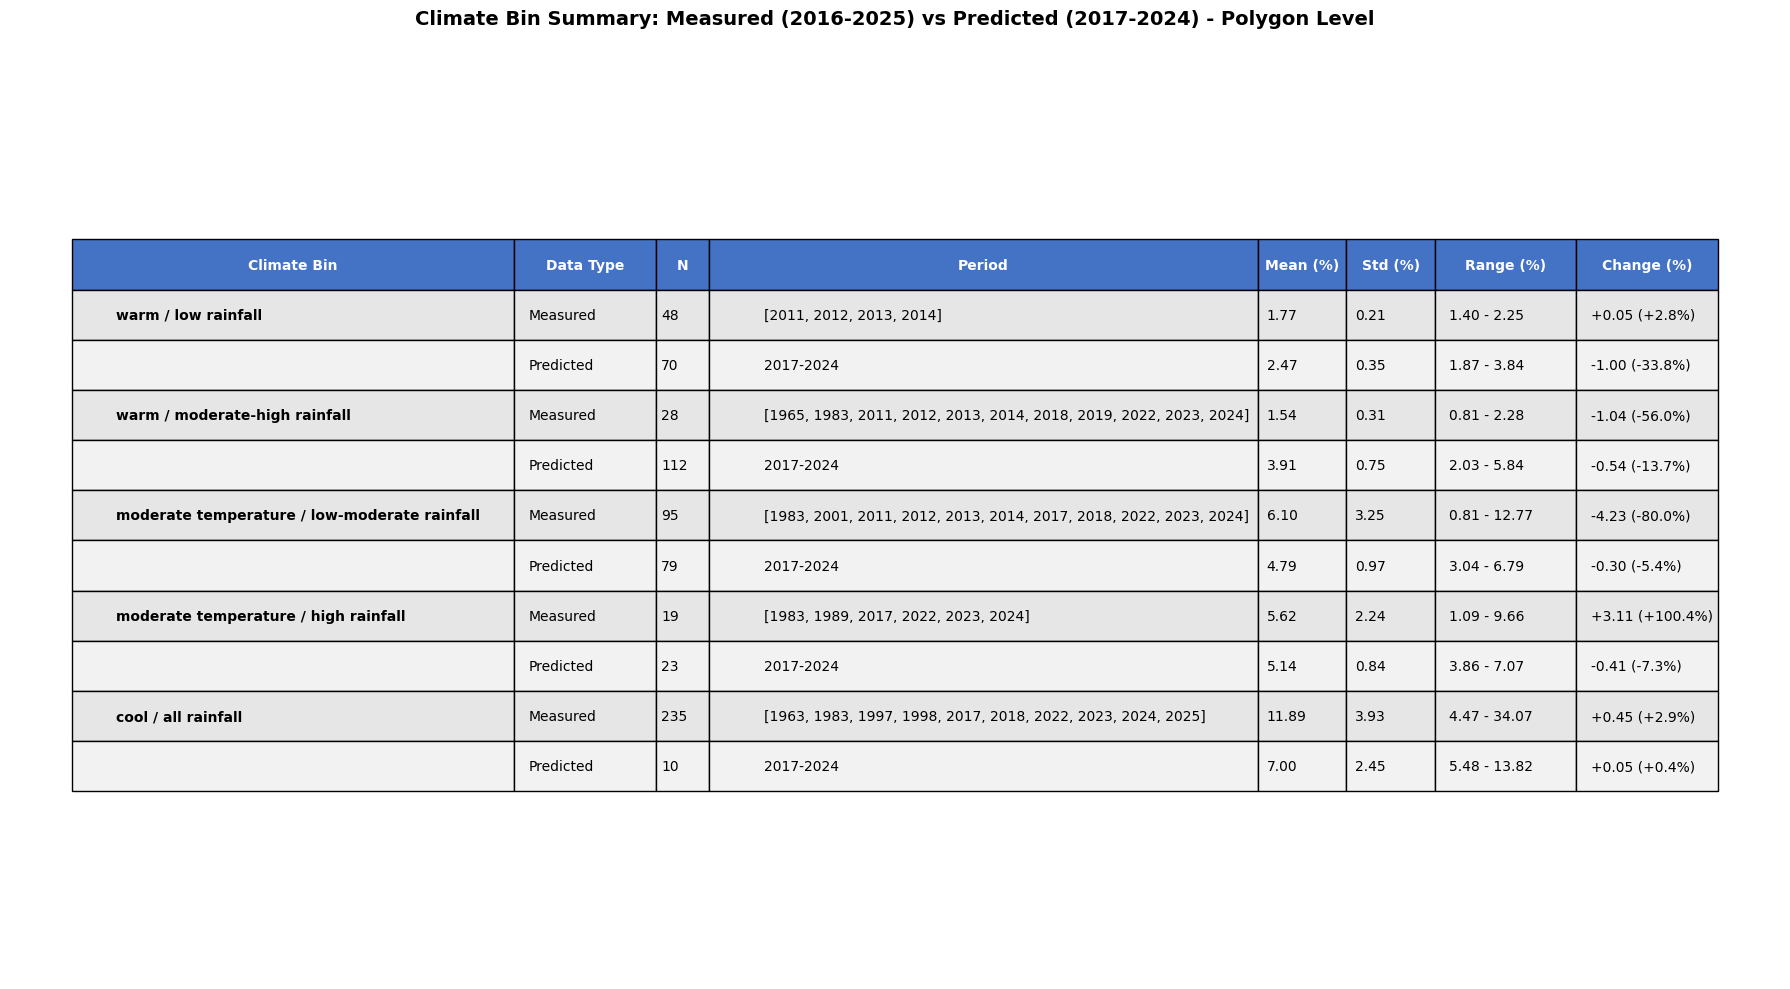

In [110]:
# Prepare the data
summary_data = []

# Get all unique climate bins from both datasets
all_climate_bins = list(dict.fromkeys(
    [c for c in climate_order if c in measured['climate_description'].values or c in polygon_summary_filtered['climate_description'].values]
))

for climate in all_climate_bins:
    # MEASURED DATA
    measured_climate_data = measured[measured['climate_description'] == climate]

    if len(measured_climate_data) > 0:
        measured_years = sorted(measured_climate_data['year_sampled'].unique())
        measured_soc = measured_climate_data['imp_c_perc']
        years_str = str([int(year) for year in measured_years])

        # Fix range to start at 0 if negative
        min_val = max(0, measured_soc.min())

        row_measured = {
            'Climate Bin': climate,
            'Data Type': 'Measured',
            'N': f"{len(measured_climate_data):,}",
            'Period': years_str,
            'Mean (%)': f"{measured_soc.mean():.2f}",
            'Std (%)': f"{measured_soc.std():.2f}",
            'Range (%)': f"{min_val:.2f} - {measured_soc.max():.2f}",
        }

        if len(measured_years) > 1:
            first_year_data = measured_climate_data[measured_climate_data['year_sampled'] == measured_years[0]]['imp_c_perc']
            last_year_data = measured_climate_data[measured_climate_data['year_sampled'] == measured_years[-1]]['imp_c_perc']

            first_year_mean = first_year_data.mean()
            last_year_mean = last_year_data.mean()
            change = last_year_mean - first_year_mean
            pct_change = (change / first_year_mean) * 100
            row_measured['Change (%)'] = f"{change:+.2f} ({pct_change:+.1f}%)"
        else:
            row_measured['Change (%)'] = 'N/A'

        summary_data.append(row_measured)
    else:
        row_measured = {
            'Climate Bin': climate,
            'Data Type': 'Measured',
            'N': '0',
            'Period': 'No data',
            'Mean (%)': '—',
            'Std (%)': '—',
            'Range (%)': '—',
            'Change (%)': '—'
        }
        summary_data.append(row_measured)

    # PREDICTED DATA (from polygon_summary_filtered)
    predicted_climate_data = polygon_summary_filtered[polygon_summary_filtered['climate_description'] == climate]

    if len(predicted_climate_data) > 0:
        # Use pre-calculated polygon-level statistics
        mean_soc = predicted_climate_data['carbon_mean'].mean()
        std_soc = predicted_climate_data['carbon_mean'].std()
        min_soc = predicted_climate_data['carbon_mean'].min()
        max_soc = predicted_climate_data['carbon_mean'].max()

        # Fix range to start at 0 if negative
        min_val = max(0, min_soc)

        row_predicted = {
            'Climate Bin': '',
            'Data Type': 'Predicted',
            'N': f"{len(predicted_climate_data):,}",
            'Period': f"{first_year}-{last_year}",
            'Mean (%)': f"{mean_soc:.2f}",
            'Std (%)': f"{std_soc:.2f}",
            'Range (%)': f"{min_val:.2f} - {max_soc:.2f}",
        }

        # Use pre-calculated change statistics
        pred_change = predicted_climate_data['carbon_change'].mean()
        pred_pct_change = predicted_climate_data['carbon_pct_change'].mean()
        row_predicted['Change (%)'] = f"{pred_change:+.2f} ({pred_pct_change:+.1f}%)"

        summary_data.append(row_predicted)

# Create DataFrame
df_table = pd.DataFrame(summary_data)

# Create figure with more width for the climate bin column
fig, ax = plt.subplots(figsize=(18, 10))
ax.axis('tight')
ax.axis('off')

# Create table with adjusted column widths
table = ax.table(cellText=df_table.values, colLabels=df_table.columns,
                cellLoc='left', loc='center',
                colWidths=[0.25, 0.08, 0.03, 0.31, 0.05, 0.05, 0.08, 0.08])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Header styling
for i in range(len(df_table.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white', wrap=True)

# Alternate row colors and climate bin highlighting
for i in range(1, len(df_table) + 1):
    row_data = df_table.iloc[i-1]

    # Highlight rows with climate bin names
    if row_data['Climate Bin'] != '':
        for j in range(len(df_table.columns)):
            cell = table[(i, j)]
            cell.set_facecolor('#E7E6E6')
            cell.set_text_props(wrap=True)  # Enable text wrapping
            if j == 0:  # Climate bin column
                cell.set_text_props(weight='bold', wrap=True)
    else:
        for j in range(len(df_table.columns)):
            cell = table[(i, j)]
            cell.set_facecolor('#F2F2F2')
            cell.set_text_props(wrap=True)  # Enable text wrapping

# Add title
plt.title(f'Climate Bin Summary: Measured (2016-2025) vs Predicted ({first_year}-{last_year}) - Polygon Level',
         fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()